In [1]:
#pip packages install Change model
%pip install patchify -q 
%pip install segmentation_models -q
%pip install keras tensorflow
%pip install pandas seaborn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 383.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.1/236.1 MB 7.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 24.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 23.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━

In [2]:
# importing required packages
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import glob
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import models
import pandas as pd
import seaborn as sns

Segmentation Models: using `tf.keras` framework.


In [3]:
#setting path to training data
path = 'UNET_training_data-20241014T071705Z-001/'
npz_files = glob.glob(path+'*/*.npz', recursive=True)
len(npz_files)
np.savetxt(path+"all_npz_files.csv", npz_files, delimiter =", ", fmt ='% s') #renaming path

In [4]:
filtered_datasets = [file for file in npz_files if 'marsh_vegetation' not in load(file)['classes']]
len(filtered_datasets)
np.savetxt(path+"filtered_npz_files.csv", filtered_datasets, delimiter =", ", fmt ='% s')

In [5]:
df = pd.read_csv(path+"filtered_npz_files.csv")
datasets = df.values.flatten().tolist()
datasets = [file for file in datasets if 'NAIP' not in file]
# len(datasets)

In [6]:
data = load(datasets[9]) #change 9 to however many images you have - change to landsat - has more images than sentinel
# print(list(data))
print(data['image'].shape)
print(data['label'].shape)
print(list(data['classes']))

np.any(np.isnan(data['image']))

(256, 256, 3)
(256, 256, 2)
['water', 'land', 'nodata']


False

img shape : (256, 256, 3)
label shape : (256, 256, 3)
classes : ['water' 'land' 'nodata']


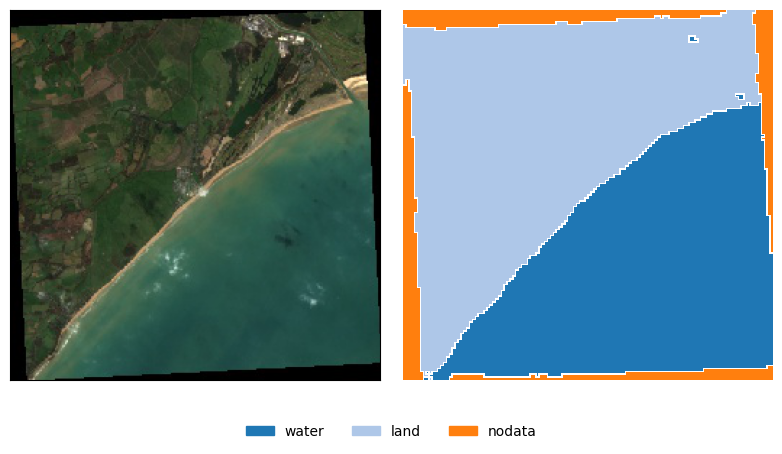

In [7]:
#@title Sanity Check
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import math
import matplotlib.patches as mpatches
import random

random_number = random.randint(0, len(datasets))
# random_number = 342
ds = load(datasets[random_number])
#print('data source:',datasets[random_number].split('/')[-2])
# ds = load('/content/drive/MyDrive/CoastTrain_dataset/Landsat8_11_001/ventura_2019-10-05-18-28-42_L8_rgb_ID2.npz')
image = ds['image']
mask = ds['label']
classes = ds['classes']

fig, ax = plt.subplots(1, 2, figsize=(8,4))
plt.box(on=None)
plt.setp(ax, xticks=[], yticks=[])

ax[0].imshow(image)
print('img shape :', image.shape)
label = mask.astype('float')
print('label shape :', label.shape)
label[label == 0] = np.nan
print('classes :', classes)

palette_tab20 = sns.color_palette('tab20', 11)

for i in range(label.shape[2]):
    new_colormap = ListedColormap(sns.color_palette([palette_tab20[i]]))
    ax[1].imshow(label[:, :, i], cmap=new_colormap)

# # create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=palette_tab20[i],label=classes[i]) for i in range(label.shape[2])]

# put those patched as legend-handles into the legend
fig.legend(handles=patches, loc='lower center', ncols=3, bbox_to_anchor=(0.5,-0.14), frameon=False)

plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/temp/categories_plot.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()